## SQLoutputPLOTTER.ipynb, SQL server glacier output plotter
### Mike Loso, 1/4/2022

## Prep temp data
This code loads up tables output from the glaciers SQL database and then plots them up. Pretty simple. 


## Load ablation stake data and calculate melt models
Then this code loads up ablation data from NPS stakes. See notes below. 



In [1]:
## IMPORT PACKAGES

# standard
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
import datetime
import os, csv

# specialized
from scipy import stats
from matplotlib import cm
# statsmodels is a nice tool for regressions
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import pickle
import numpy.ma as ma
import matplotlib.dates as mdates

# set default figure size
figsize=(10,6)

### Import ablation records from NPS stakes
Next I import a record of measured ablation totals from Kennicott Glacier (KennSummerAblation.xlsx). These were exported from the SQL Glaciers database using a saved query. It is expored with the columns 'Site', 'Date_Time', 'Latitude', 'Longitude', 'HAMSL_m', 'Melt_Season_SWE_Change_m', 'LastVisitDate', 'DaysSinceLastVisit'. I manually added 'IceSnow', which describes the surface that was melting at the beginning/end of the melt season, respectively, and also 'Summ_Accum', which could have been part of the query but I didn't think of it. Note that melt season change ignores summer accum (reflects the surface under the summer accum), and the summ_accum--when it shows up, stops the melt season (if it persists).

Also, there is one duplicate record that comes out of the SQL server export as of 12/4/2021: two versions of Kenn6100 in 2019. The one with a melt season change of -2.805 is preferred, so I manually removed a record with change of -2.746. I also separated out 3 records from Gates 7200 that have such small melt responses that I think they skew the DDF calculation, likely because they received significant mid-summer precip. I called them "snow/snow/suspect" in the IceSnow category. This could be fixed in db query somehow in the future.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
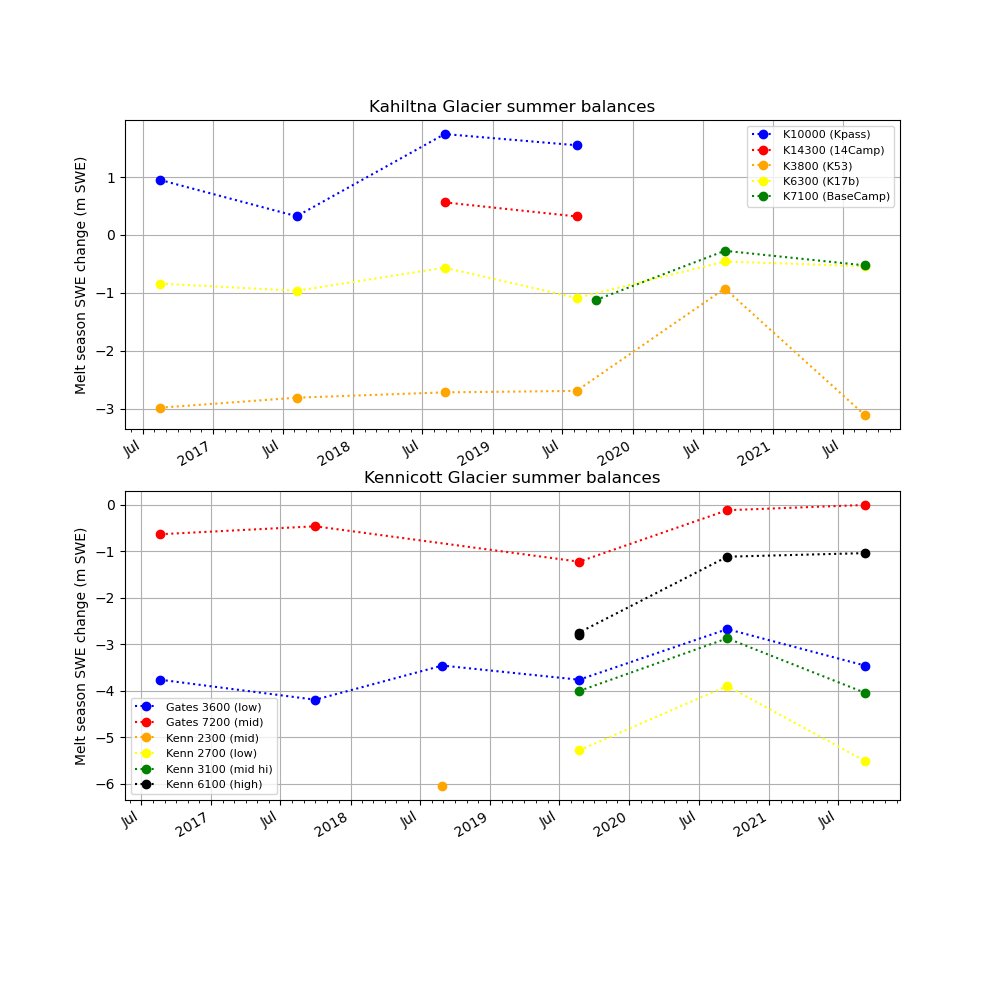

In [2]:
## LOAD ABLATION DATA
# set working directory
data_dir = r'~/MLo/KennGlac/data/SQLoutput_2022_01_04'
# Load an csv workbooks that are in the local directory
csvkenn=os.path.join(data_dir,'KennicottAblationBySite.csv')
csvkah=os.path.join(data_dir,'KahiltnaAblationBySite.csv')

# Load the first worksheet as 'kennablat' or 'kahablat', treat NULL as nan, make second column (Date_Time) the index
kennablat=pd.read_csv(csvkenn,header=0,parse_dates=['Date_Time'],na_values=['NULL'],index_col=[1])
kahablat=pd.read_csv(csvkah,header=0,parse_dates=['Date_Time'],na_values=['NULL'],index_col=[1])


# VIEW RAW DATA

# # Print summary of worksheet ('kennablat')
# print(kahablat.head())
# # Print datatypes (dtypes) of DataFrame (wb)
# print(kennablat.dtypes)

# Plot with each site its own color
# create array of colors and start count at 0
colors=['blue','red','orange','yellow','green','black']

fig, axs=plt.subplots(nrows=2, ncols=1, figsize=(10,10))

# group entries by site, then for each group
groupedkah = kahablat.groupby('Site')
groupedkenn = kennablat.groupby('Site')

# loop through each group
# key is the ordered list of sites (the grouping variable)
# group is the ordered list of rows in each group
# use_index forces 'plot' to use the index (Date_Time) as the x axis

# restart color key
colorkey=0

ax=axs[0]
for key, group in groupedkah:
    group.plot(ax=ax, use_index=True, y='Melt_Season_SWE_Change_m', label=key, color=colors[colorkey], marker='o', linestyle='dotted')
# increment the colorkey
    colorkey=colorkey+1
    ax.legend(loc='upper right',fontsize=8)
    ax.set_title('Kahiltna Glacier summer balances')
    ax.set_xlabel('')
    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.grid(True)
    ax.set_ylabel('Melt season SWE change (m SWE)')
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# restart color key
colorkey=0

ax=axs[1]
for key, group in groupedkenn:
    group.plot(ax=ax, use_index=True, y='Melt_Season_SWE_Change_m', label=key, color=colors[colorkey], marker='o',linestyle='dotted')
# increment the colorkey
    colorkey=colorkey+1
    ax.legend(loc='lower left',fontsize=8)
    ax.set_title('Kennicott Glacier summer balances')
    ax.set_xlabel('')
    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.grid(True)
    ax.set_ylabel('Melt season SWE change (m SWE)')
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.show()



IndexError: list index out of range

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
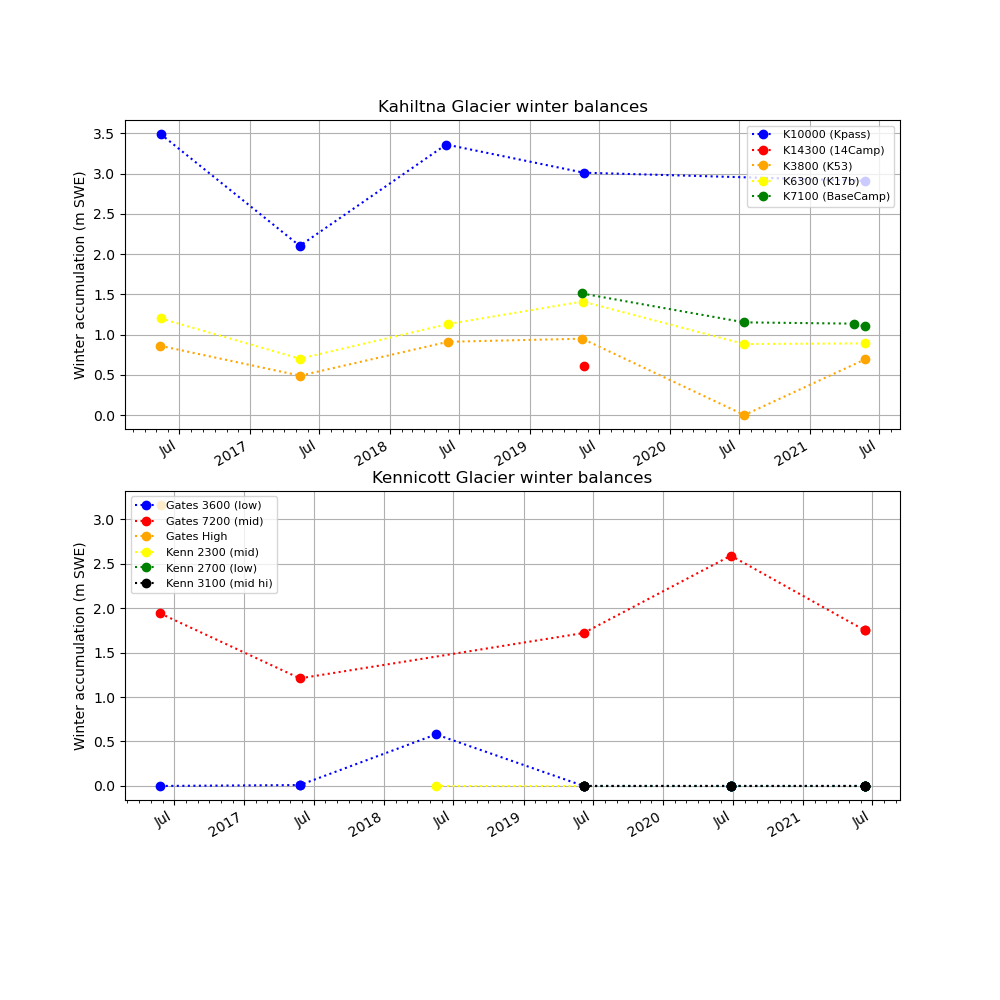

In [3]:
## LOAD ACCUMULATION DATA
# set working directory
data_dir = r'~/MLo/KennGlac/data/SQLoutput_2022_01_04'
# Load an csv workbooks that are in the local directory
csvkenn=os.path.join(data_dir,'KennicottAccumulation.csv')
csvkah=os.path.join(data_dir,'KahiltnaAccumulation.csv')

# Load the first worksheet as 'kennablat' or 'kahablat', treat NULL as nan, make second column (Date_Time) the index
kennaccum=pd.read_csv(csvkenn,header=0,parse_dates=['Date_Time'],na_values=['NULL'],index_col=[1])
kahaccum=pd.read_csv(csvkah,header=0,parse_dates=['Date_Time'],na_values=['NULL'],index_col=[1])


# VIEW RAW DATA

# # Print summary of worksheet ('kennablat')
# print(kahablat.head())
# # Print datatypes (dtypes) of DataFrame (wb)
# print(kennablat.dtypes)

# Plot with each site its own color
# create array of colors and start count at 0
colors=['blue','red','orange','yellow','green','black']

fig, axs=plt.subplots(nrows=2, ncols=1, figsize=(10,10))

# group entries by site, then for each group
groupedkah = kahaccum.groupby('Site')
groupedkenn = kennaccum.groupby('Site')

# loop through each group
# key is the ordered list of sites (the grouping variable)
# group is the ordered list of rows in each group
# use_index forces 'plot' to use the index (Date_Time) as the x axis

# restart color key
colorkey=0

ax=axs[0]
for key, group in groupedkah:
    group.plot(ax=ax, use_index=True, y='Seasonal_Snow_SWE_m', label=key, color=colors[colorkey], marker='o', linestyle='dotted')
# increment the colorkey
    colorkey=colorkey+1
    ax.legend(loc='upper right',fontsize=8)
    ax.set_title('Kahiltna Glacier winter balances')
    ax.set_xlabel('')
    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.grid(True)
    ax.set_ylabel('Winter accumulation (m SWE)')
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# restart color key
colorkey=0

ax=axs[1]
for key, group in groupedkenn:
    group.plot(ax=ax, use_index=True, y='Seasonal_Snow_SWE_m', label=key, color=colors[colorkey], marker='o',linestyle='dotted')
# increment the colorkey
    colorkey=colorkey+1
    ax.legend(loc='upper left',fontsize=8)
    ax.set_title('Kennicott Glacier winter balances')
    ax.set_xlabel('')
    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.grid(True)
    ax.set_ylabel('Winter accumulation (m SWE)')
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.show()

